# Analysis of Error Bound for Smooth Markets
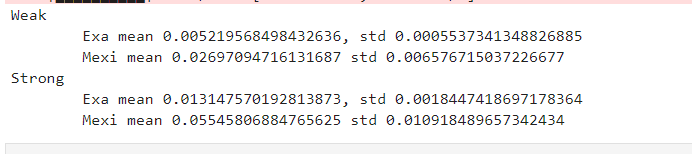

In [5]:
import os
import sys
import numpy as np
from time import perf_counter as timer

root_path = os.path.join(os.path.expanduser('~'), 'bnelearn')
if root_path not in sys.path:
    sys.path.append(root_path)

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
    
import bnelearn
from bnelearn.experiment.configuration_manager import ConfigurationManager
import bnelearn.util.metrics as metrics

In [6]:
COLORS = ("#0E6BA0", "#973D4C", "#30C0D2", 'blue', 'green')
specific_gpu = 1
torch.cuda.set_device(specific_gpu)

In [7]:
n_runs = 10
valuations = np.array([0.1, 0.8, 0.9])
temperatures = np.linspace(0.00001, 0.05, 50)

In [8]:
experiment_type = 'single_item_uniform_symmetric'
sys.stdout = open(os.devnull, 'w')  # block all prints

log_root_dir = os.path.join(os.path.expanduser('~'), 'bnelearn', 'experiments', 'smooth')
utility_error = np.zeros(
    (n_runs, valuations.shape[0], temperatures.shape[0]), dtype=float)

for seed, run in enumerate(range(n_runs)):
    for i, valuation in enumerate(valuations):
        for j, temperature in enumerate(temperatures):
            
            # Setup environment
            experiment_config, experiment_class = \
                ConfigurationManager(
                    experiment_type=experiment_type,
                    n_runs=1, n_epochs=0, seeds=[seed]
                ) \
                .set_learning(
                    batch_size=2**18,
                    pretrain_iters=0,
                    smoothing_temperature=temperature
                ) \
                .set_logging(enable_logging=False) \
                .set_hardware(specific_gpu=specific_gpu) \
                .get_config()

            experiment = experiment_class(experiment_config)
            experiment._init_new_run()

            # BNE strategies
            for bidder, bne_bidder in zip(experiment.bidders, experiment.bne_env[0].agents):
                bidder.strategy = bne_bidder.strategy
            opponent_slope = 0.5

            # # Or custom strategies
            # class Strat:
            #     def __init__(self, slope: float=0.5, const: bool=False):
            #         self.slope = slope
            #         self.const = const
            #     def play(self, valuation):
            #         if self.const:
            #             return 0.4 * torch.ones_like(torch.tensor(valuation))
            #         return self.slope * torch.tensor(valuation)
            # experiment.bidders[0].strategy = Strat(.3, const=True)
            # opponent_slope = .4
            # experiment.bidders[1].strategy = Strat(opponent_slope)

            # Calculate utilities
            experiment.env._observations[:, 0, 0] = valuation
            actual_utility = experiment.env.get_reward(
                agent=experiment.bidders[0],
                aggregate=True,
                smooth_market=False
            )
            smooth_utility = experiment.env.get_reward(
                agent=experiment.bidders[0],
                aggregate=True,
                smooth_market=True
            )

            # bidder 0 only
            # utility_error[run, i, j] = (actual_utility - smooth_utility).mean()
            utility_error[run, i, j] = torch.abs(actual_utility - smooth_utility).mean()

/home/kohring/bnelearn/bnelearn/experiment/single_item_experiment.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bne_utility = torch.tensor(
/home/kohring/.conda/envs/bnelearn-test/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
from sympy.functions.special.zeta_functions import polylog

def utility(v1, b1, s):
    return (v1-b1) * (b1/s)

def first_int_vol(v1, b1, lam, s):
    return - ((b1-v1)/s) * (
        lam*np.log(np.exp(b1/lam)+1) - lam*np.log(2*np.exp(b1/lam)) + b1)

def second_int_vol(v1, b1, lam, s):
    integral = 0
    integral += lam * (s*np.log(np.exp(s/lam - b1/lam) + 1) - b1*np.log(2))
    integral += (lam**2) * (polylog(2, -np.exp((s-b1)/lam)) + (1/12)*np.pi**2)
    integral += v1*lam * (np.log(2) + b1/lam - np.log(np.exp(s/lam) + np.exp(b1/lam)))
    integral += -0.5*(s**2 - b1**2) + v1*(s-b1)
    return float(integral) / s

def exact_interim_error(lams, v1, b1, s):
    error = np.zeros_like(lams)
    for i, lam in enumerate(lams):
        error[i] += -s * np.log(np.exp((s-b1)/lam) + 1)
        error[i] += -lam * (polylog(2, -np.exp((s-b1)/lam)) + (1/12)*np.pi**2)
        error[i] += v1 * np.log(np.exp(s/lam) + np.exp(b1/lam))
        error[i] += (1/lam) * (0.5*(s**2 - b1**2) - v1*s)
        error[i] += (b1-v1) * np.log(np.exp(-b1/lam) + 1)
        error[i] *= (lam/s)
    return abs(error)

def approx_ex_ante_error(lams, strat, s):
    error = np.zeros_like(lams)
    N = 100
    v1s = np.random.uniform(0, 1, N)
    for i, v1 in enumerate(v1s):
        error += exact_interim_error(lams, v1, strat(v1), s)
    error /= 100
    return error

In [10]:
strat = lambda v: experiment.bidders[0].strategy.play(v).cpu().numpy()
approx_ex_ante_error_vec = approx_ex_ante_error(temperatures, strat, opponent_slope)

/tmp/ipykernel_468122/1335622235.py:21: RuntimeWarning: overflow encountered in exp
  error[i] += -s * np.log(np.exp((s-b1)/lam) + 1)
/tmp/ipykernel_468122/1335622235.py:22: RuntimeWarning: overflow encountered in exp
  error[i] += -lam * (polylog(2, -np.exp((s-b1)/lam)) + (1/12)*np.pi**2)
/tmp/ipykernel_468122/1335622235.py:23: RuntimeWarning: overflow encountered in exp
  error[i] += v1 * np.log(np.exp(s/lam) + np.exp(b1/lam))


/tmp/ipykernel_468122/1335622235.py:21: RuntimeWarning: overflow encountered in exp
  error[i] += -s * np.log(np.exp((s-b1)/lam) + 1)
/tmp/ipykernel_468122/1335622235.py:22: RuntimeWarning: overflow encountered in exp
  error[i] += -lam * (polylog(2, -np.exp((s-b1)/lam)) + (1/12)*np.pi**2)
/tmp/ipykernel_468122/1335622235.py:23: RuntimeWarning: overflow encountered in exp
  error[i] += v1 * np.log(np.exp(s/lam) + np.exp(b1/lam))
/tmp/ipykernel_468122/1335622235.py:21: RuntimeWarning: overflow encountered in exp
  error[i] += -s * np.log(np.exp((s-b1)/lam) + 1)
/tmp/ipykernel_468122/1335622235.py:22: RuntimeWarning: overflow encountered in exp
  error[i] += -lam * (polylog(2, -np.exp((s-b1)/lam)) + (1/12)*np.pi**2)
/tmp/ipykernel_468122/1335622235.py:23: RuntimeWarning: overflow encountered in exp
  error[i] += v1 * np.log(np.exp(s/lam) + np.exp(b1/lam))
/tmp/ipykernel_468122/1335622235.py:21: RuntimeWarning: overflow encountered in exp
  error[i] += -s * np.log(np.exp((s-b1)/lam) + 1)


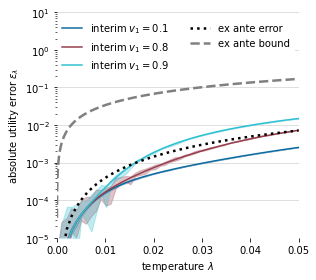

In [11]:
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, valuation in enumerate(valuations):
    mean, std = utility_error[:, i, :].mean(axis=0), utility_error[:, i, :].std(axis=0)
    # plt.plot(temperatures, mean, ms=7, color=COLORS[i], label=f'interim $v_1 = {valuation}$')
    plt.fill_between(temperatures, mean-std, mean+std, alpha=.3, color=COLORS[i])

    # Theoretical error
    plt.plot(temperatures, exact_interim_error(temperatures, valuation, strat(valuation), opponent_slope),
             color=COLORS[i], label=f'interim $v_1 = {valuation}$')

# Theoretical ex ante error
plt.plot(temperatures, approx_ex_ante_error_vec, ':', linewidth=2.5, label='ex ante error', color='black')

temperatures_high_res = np.linspace(temperatures[0], temperatures[-1], 1000)
# Theoretical ex ante bound
plt.plot(temperatures_high_res, ((np.log(2) + 1)/0.5) * temperatures_high_res, '--', linewidth=2.5, label='ex ante bound', color='grey')

# Formatting
ax.set_xlabel('temperature $\lambda$'); ax.set_ylabel(r'absolute utility error $\epsilon_\lambda$')
plt.yscale('log')
ax.set_xlim(0, 0.05); ax.set_ylim(0.00001, 10)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
plt.legend(loc='upper right', ncol=2, framealpha=1, edgecolor="white")
ax.grid(which='major', axis='y', alpha=.5)
plt.tight_layout(); plt.savefig('smooth-error-bound.pdf'); plt.savefig('smooth-error-bound.png', dpi=300)
plt.show()

In [12]:
# # TODO: For old payment rule
# from sympy.functions.special.zeta_functions import polylog
# from scipy.special import zeta

# def ante_bound(temperatures):
#     bounds = np.zeros_like(temperatures)
#     for i, temperature in enumerate(temperatures):
#         bounds[i] += -temperature**3 * (4 * polylog(3, -np.exp(1/(2 * temperature))) + 6 * zeta(3)) 
#         bounds[i] += -4 * temperature**3 * polylog(3, -np.exp(-1/(2 * temperature))) 
#         bounds[i] += -2 * temperature**2 * polylog(2, -np.exp(-1/(2 * temperature))) 
#         bounds[i] += - (np.pi**2 * temperature**2)/6 - (1/12)
#     return bounds

# lam = 0.02
# print(f"The ex ante bound for $\lambda={lam}$ is {ante_bound([lam])}")

In [13]:
# temperature = 0.02

# valuations = np.linspace(0, 1, 100)
# bids = np.linspace(0, .6, 100)
# epsilon = np.zeros((valuations.shape[0], bids.shape[0]))

# for i, valuation in enumerate(valuations):
#     for j, bid in enumerate(bids):
#         epsilon[i, j] = temperature * abs((valuation - bid)/opponent_slope) \
#                 * abs(np.log(np.exp((bid - opponent_slope)/temperature)) \
#                 + np.log(np.exp(bid/temperature) + np.exp(opponent_slope/temperature)) \
#                 - np.log(np.exp(bid/temperature) + 1))

# fig, ax = plt.subplots(figsize=(4.5, 4))

# ax.plot([0, 1], [0, 0.5], '--', color='black')
# x, y = np.meshgrid(valuations, bids)
# epsilon = epsilon.T
# ax.pcolormesh(x, y, epsilon, alpha=.5)
# CS = plt.contour(x, y, epsilon, levels=10)
# ax.clabel(CS, CS.levels[::3], inline=True, fontsize=10)

# ax.set_xlabel('valuation $v_1$'); ax.set_ylabel('bid $b_1$')
# ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
# ax.grid(which='major', alpha=.5)
# plt.tight_layout(); plt.savefig('smooth-error-bound-heatmap.pdf')
# ax.set_box_aspect(); plt.show()

In [14]:
# softmax_function = torch.nn.Softmax(0)
# temperature = .06

# x = torch.linspace(-1, 1, 1000)
# y = 0 * torch.ones_like(x)

# softmax = softmax_function((1/temperature) * torch.concat([x.view(1, -1), y.view(1, -1)], axis=0))

# softmax_1 = softmax[0, :]
# softmax_2 = softmax[1, :]
# derivative = (1/temperature) * softmax_1 * softmax_2

# plt.plot(x, softmax_1, '--')
# plt.plot(x, derivative)

# n = 100
# step_size = 0.1
# for xx, f, d in zip(x[::n], softmax_1[::n], derivative[::n]):
#     plt.arrow(xx, f, step_size, step_size*d, color='grey', head_width=.03)
# plt.legend(); plt.show()